# Aggregated Cluster-Based BiTE profiles
Aggregate cluster-based morphological profiles by condition (drug and concentration) to generate bispecific antibody profiles that characterize clusters of B and T cells.

In [1]:
# load third-party Python modules
import javabridge
import bioformats as bf
import skimage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import re
import os
import sys
import h5py
import json
from sklearn.manifold import TSNE


In [2]:
annot_df = pd.read_csv('../data/BiTE/bite_annot.csv')

In [3]:
annot_df = annot_df[~np.isin(annot_df['PatientID'], 
                  ['17LN0054',
                   '17LN0055'])].reset_index(drop=True)

In [4]:
prof_dir = '../data/clustbite_mean_profiles/'

In [5]:
plates = os.listdir(prof_dir)

In [6]:
data_all = []
for plate in plates:
    imgdf = pd.read_csv(os.path.join(prof_dir, plate))
    annot_plate = annot_df[annot_df['plate']==plate.replace('.csv', '')]
    plate_df = pd.merge(imgdf, annot_plate[['well', 'PatientID', 'comb']],on='well')
    plate_df = plate_df.groupby(['PatientID', 'comb'], as_index=False).agg('mean')
    plate_df.index = plate_df['comb']
    plate_df = plate_df.drop('comb', axis=1)
    data_all.append(plate_df)

In [7]:
df_all = pd.concat(data_all)

In [8]:
# remove wells with low counts
df_all = df_all[df_all['count'] > 9]
df_all = df_all.drop('count', axis=1)

In [9]:
df_all.to_csv('../data/BiTE/clustbite_all.csv')

In [10]:
df_wide = pd.pivot_table(df_all, index=df_all.index, columns='PatientID')

In [11]:
df_wide.shape

(74, 540)

/opt/miniconda3/envs/MLnew/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



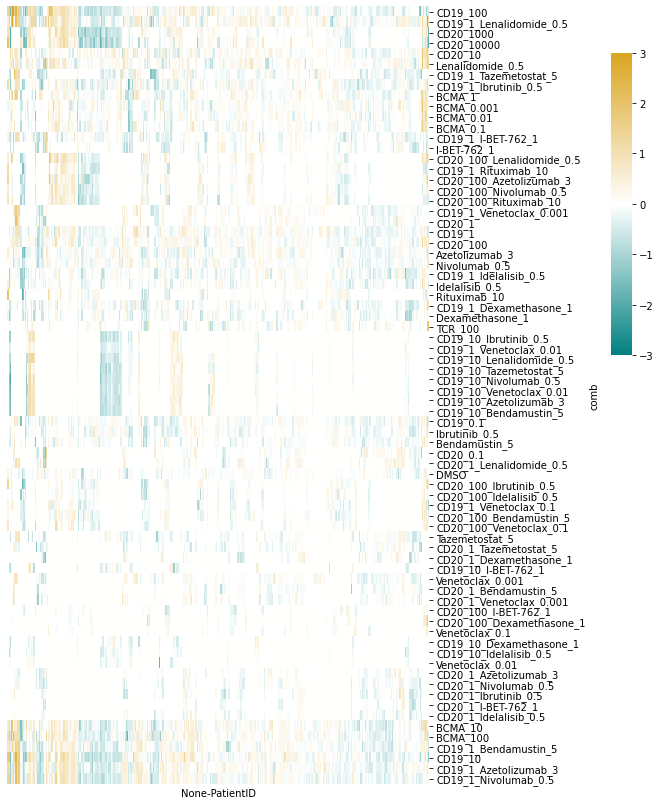

In [12]:
from bioimg.singlecell import plot_heatmap
plot_heatmap(df_wide.fillna(0), xticklabels=False, size=(10,14),
            yticklabels=True, vmin=-3, vmax=3)

In [13]:
df_wide.columns = df_wide.columns.map('|'.join)

In [14]:
df_wide.head()

,ch-APC-area|17LN0002,ch-APC-area|17LN0024,ch-APC-area|17LN0025,ch-APC-area|17LN0027,ch-APC-area|17LN0028,ch-APC-area|17LN0029,ch-APC-area|17LN0046,ch-APC-area|17LN0050,ch-APC-area|18LN0077,ch-APC-area|18LN0078,...,ch-PE-solidity|18LN0118,ch-PE-solidity|18LN0120,ch-PE-solidity|18LN0121,ch-PE-solidity|18LN0124,ch-PE-solidity|18LN0125,ch-PE-solidity|18LN0128,ch-PE-solidity|18LN0130,ch-PE-solidity|19LN0135,ch-PE-solidity|19LN0144,ch-PE-solidity|19LN0147
comb,,,,,,,,,,,,,,,,,,,,,
Azetolizumab_3,-0.204961,-0.507247,0.049562,0.051723,-0.477960,-0.137406,0.018302,0.190657,0.173492,0.167366,...,NaN,0.266503,-0.008064,NaN,0.297883,-0.014780,-0.225792,-0.054440,0.017087,0.041334
BCMA_0.001,-0.467008,0.185352,-0.218260,-0.119070,0.271544,0.227069,-0.050263,0.091126,NaN,-0.084915,...,-0.158726,0.004082,0.290643,NaN,NaN,NaN,-0.219194,0.026122,0.238102,0.048588
BCMA_0.01,-0.109115,NaN,-0.003852,0.271134,0.022213,-0.127084,-0.177577,0.235110,NaN,0.448771,...,-0.132033,0.395337,0.088506,NaN,NaN,NaN,-0.037551,0.141678,0.059689,-0.076715
BCMA_0.1,-0.508331,NaN,-0.009559,-0.186604,0.226436,0.719286,0.005058,0.217751,NaN,0.032324,...,-0.716375,NaN,0.057395,NaN,NaN,NaN,0.077280,-0.248919,0.010784,0.154762
BCMA_1,-0.122689,NaN,-0.036347,0.050796,0.158977,-0.141393,-0.001469,0.010693,NaN,0.277870,...,-0.082706,NaN,0.182339,NaN,NaN,-0.176889,-0.132064,-0.088882,0.424342,0.148956


In [15]:
#df_wide.to_csv('../data/all_clustbite_profiles.csv')

Collapse concentrations:

In [16]:
combs = annot_df.apply(lambda x: '_'.join([x['BiTE'], x['Drug']]), axis=1).values

In [17]:
combs[combs=='DMSO_DMSO'] = 'DMSO'
combs = [c.replace("_DMSO", '') for c in combs]
combs = [c.replace("DMSO_", '') for c in combs]

In [18]:
annot_df['comb'] = combs

In [19]:
data_all = []
for plate in plates:
    imgdf = pd.read_csv(os.path.join(prof_dir, plate))
    annot_plate = annot_df[annot_df['plate']==plate.replace('.csv', '')]
    plate_df = pd.merge(imgdf, 
                        annot_plate[['well', 'PatientID', 'comb']],on='well')
    
    if plate_df.size:
        # remove wells with low counts
        plate_df = plate_df[plate_df['count'] > 5]
        plate_df = plate_df.drop('count', axis=1)

        # take extreme values
        plate_df = (plate_df.
                    groupby(['PatientID', 'comb'],
                            as_index=False).
                    agg(lambda x: np.max(x) if np.abs(np.max(x)) > np.abs(np.min(x)) else np.min(x)))
        plate_df.index = plate_df['comb']
        plate_df = plate_df.drop('comb', axis=1)
        data_all.append(plate_df)

In [20]:
df_all = pd.concat(data_all)
df_wide = pd.pivot_table(df_all, index=df_all.index, columns='PatientID')
df_wide.columns = df_wide.columns.map('|'.join)

In [21]:
#df_wide.to_csv('../data/clustbite_comb_profiles.csv')

In [22]:
df_wide.max().max()

4.686250364329969

In [23]:
df_wide.min().min()

-2.3026637322446497